In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt # package for plotting
import numpy as np # package for numerical analyis
from qutip.qip.circuit_latex import _latex_compile

In [2]:
from qutip import *

In [3]:
perfect_fid = 0
array_analysis = 0

# Ion Trap Architecture Gates

Implementation of the quantum logic gates for ion trap architecture. Utilized Krauss Superoperator (discrete time unitaries) rather than Linblad to model decoherence in gate operations. Fidelities of primitive gate operations(RX,RY,IsingXX) were taken from Debnath paper[1].

In [4]:
""" 
Ion Trap Architecture
- Create gate operators will fidelity from Debnath paper (Single qubit rotations and XX Ising gate)
- Will use Krauss superoperator formalism rather than Linblad 
"""

def RX(state,N,qubit,theta,direction):
    """
    RX - Single qubit rotation about X-axis 
    
    Inputs:
    - state: density matrix for given circuit state
    - N: number of qubits in circuit
    - qubit: numeric value to indicate which qubit to rotate, in for tensor(qubit_0,qubit_1,...,qubit_N)
    - theta: angle to rotate by
    - direction: numeric value to rotate by +X (1) or -X axis (-1)
    
    Outputs:
    returns Qobj of rotated state
    """

    if(perfect_fid):
        fidelity = 1
    else:
        fidelity = np.sqrt(0.991)
    
    
    #create rotation matrix of correct dimension, with rotation-x decomposition. Noise is by over rotating (Z-noise)
    for i in range(N):
        if(i == 0 and i != qubit):
            rot_mat = qeye(2)
            noise = qeye(2)
        elif(i == 0 and i == qubit):
            rot_mat = fidelity*(np.cos(theta/2)*qeye(2)- direction*1j*np.sin(theta/2)*sigmax())
            noise = (1-fidelity)*sigmaz()
        elif(i!=0 and i==qubit):
            rot_mat = tensor(rot_mat,fidelity*(np.cos(theta/2)*qeye(2)- direction*1j*np.sin(theta/2)*sigmax()))
            noise = tensor(noise,(1-fidelity)*sigmaz())
        else:
            rot_mat = tensor(rot_mat,qeye(2))
            noise = tensor(noise,qeye(2))
    
    rot_state = (rot_mat+noise)*state*(rot_mat+noise).dag()
    return rot_state


def RY(state,N,qubit,theta,direction):
    """
    RY - Single qubit rotation about Y-axis 
    
    Inputs:
    - state: density matrix for given circuit state
    - N: number of qubits in circuit
    - qubit: numeric value to indicate which qubit to rotate, in for tensor(qubit_0,qubit_1,...,qubit_N)
    - theta: angle to rotate by
    - direction: numeric value to rotate about +Y or -Y axis
    
    Outputs:
    returns Qobj of rotated state
    """

    if(perfect_fid):
        fidelity = 1
    else:
        fidelity = np.sqrt(0.991)
    
    #create rotation matrix of correct dimension, with rotation-x decomposition. Noise is by over rotating (Z-noise)
    for i in range(N):
        if(i == 0 and i != qubit):
            rot_mat = qeye(2)
            noise = qeye(2)
        elif(i == 0 and i == qubit):
            rot_mat = fidelity*(np.cos(theta/2)*qeye(2)- direction*1j*np.sin(theta/2)*sigmay())
            noise = (1-fidelity)*sigmaz()
        elif(i!=0 and i==qubit):
            rot_mat = tensor(rot_mat,fidelity*(np.cos(theta/2)*qeye(2)- direction*1j*np.sin(theta/2)*sigmay()))
            noise = tensor(noise,(1-fidelity)*sigmaz())
        else:
            rot_mat = tensor(rot_mat,qeye(2))
            noise = tensor(noise,qeye(2))
    

    rot_state = (rot_mat+noise)*state*(rot_mat+noise).dag()
    return rot_state


def RZ(state,N,qubit,theta,direction):
    """
    RZ - Single qubit rotation about Z-axis 
    
    Inputs:
    - state: density matrix for given circuit state
    - N: number of qubits in circuit
    - qubit: numeric value to indicate which qubit to rotate, in for tensor(qubit_0,qubit_1,...,qubit_N)
    - theta: angle to rotate by
    - direction: numeric value to rotate about +Z or -z axis
    
    Outputs:
    returns Qobj of rotated state
    """

    if(perfect_fid):
        fidelity = 1
    else:
        fidelity = np.sqrt(0.991)*np.sqrt(0.991)*np.sqrt(0.991) #ion trap architecture implemented this as RY*RX*RY

    
    #create rotation matrix of correct dimension, with rotation-x decomposition. Noise is by over rotating (Z-noise)
    for i in range(N):
        if(i == 0 and i != qubit):
            rot_mat = qeye(2)
            noise = qeye(2)
        elif(i == 0 and i == qubit):
            rot_mat = fidelity*(np.cos(theta/2)*qeye(2)- direction*1j*np.sin(theta/2)*sigmaz())
            noise = (1-fidelity)*sigmaz()
        elif(i!=0 and i==qubit):
            rot_mat = tensor(rot_mat,fidelity*(np.cos(theta/2)*qeye(2)- direction*1j*np.sin(theta/2)*sigmaz()))
            noise = tensor(noise,(1-fidelity)*sigmaz())
        else:
            rot_mat = tensor(rot_mat,qeye(2))
            noise = tensor(noise,qeye(2))
    

    rot_state = (rot_mat+noise)*state*(rot_mat+noise).dag()
    return rot_state

def T(state,N,qubit):
    """
    T - Phase gate by pi/4 
    
    Inputs:
    - state: density matrix for given circuit state
    - N: number of qubits in circuit
    - qubit: numeric value to indicate which qubit to rotate, in for tensor(qubit_0,qubit_1,...,qubit_N)

    
    Outputs:
    returns Qobj of rotated state
    """
    
    rot_state = (np.exp(np.pi/8)/np.sqrt(np.exp(np.pi/4)))*RZ(state,N,qubit,np.pi/4,1)
    return rot_state


def T_dag(state,N,qubit):
    """
    T - Phase gate by pi/4 
    
    Inputs:
    - state: density matrix for given circuit state
    - N: number of qubits in circuit
    - qubit: numeric value to indicate which qubit to rotate, in for tensor(qubit_0,qubit_1,...,qubit_N)

    
    Outputs:
    returns Qobj of rotated state
    """
    
    rot_state = (np.exp(-1*np.pi/8)/np.sqrt(np.exp(-1*np.pi/4)))*RZ(state,N,qubit,-1*np.pi/4,1)
    return rot_state

def IsingXX(state,N,qubit1,qubit2,theta):
    """
    Ising-gate that invokes sigmax()-sigmax() interaction between qubits 1&2
    
    Inputs:
    - state: density matrix for given circuit state
    - N: number of qubits in circuit
    - qubit1/2: numeric value to indicate which qubits interact, in for tensor(qubit_0,qubit_1,...,qubit_N)
    - theta: angle to rotate by; note this should include sign (alpha)
    
    Outputs:
    returns Qobj of interacted state
    """

    #initialize sign of geometric phase - alpha
    if((qubit1 == 1 and qubit2 == 5) or (qubit1 == 5 and qubit2 == 1)
      or (qubit1 == 2 and qubit2 == 5) or (qubit1 == 5 and qubit2 == 2)
      or (qubit1 == 1 and qubit2 == 3) or (qubit1 == 3 and qubit2 == 1)):
        alpha = -1
    else:
        alpha = 1
        
    phase = (alpha*np.abs(theta))/4

    
    if(perfect_fid):
        fidelity = 1
    else:
        fidelity = np.sqrt(0.991)
    
    order = list(range(N))
    
    if qubit1 == 0 and qubit2 == 1:
        order[qubit2], order[qubit1] = order[qubit1], order[qubit2]

    elif qubit1 == 0:
        order[1], order[qubit1] = order[qubit1], order[1]
        order[1], order[qubit2] = order[qubit2], order[1]

    else:
        order[1], order[qubit1] = order[qubit1], order[1]
        order[0], order[qubit2] = order[qubit2], order[0]
    
    int_mat = fidelity*(np.cos(phase)*tensor(qeye(2),qeye(2)) - 1j*np.sin(phase)*tensor(sigmax(),sigmax()))
    int_mat = int_mat + (1-fidelity)*tensor(sigmaz(),sigmaz())
    int_mat = tensor([int_mat] + (N-2)*[qeye(2)]).permute(order)
    int_state = int_mat*state*int_mat.dag()
    return int_state


def CNOT(state,N,qubit1,qubit2):
    """
    CNOT - Controlled-Not Gate. Composite gate of:
        - RY,RX,RZ,IsingXX
    
    Inputs:
    - state: density matrix for given circuit state
    - N: number of qubits in circuit
    - qubit1: numeric value to indicate target qubit, in form tensor(qubit_0,qubit_1,...,qubit_N)
    - qubit2: numberic value to indicate control qubit, in form tensor(qubit_0,qubit_1,...,qubit_N)
    
    Outputs:
    returns Qobj of CNOT state
    """
    
    #initialize sign of geometric phase - alpha
    if((qubit1 == 1 and qubit2 == 5) or (qubit1 == 5 and qubit2 == 1)
      or (qubit1 == 2 and qubit2 == 5) or (qubit1 == 5 and qubit2 == 2)
      or (qubit1 == 1 and qubit2 == 3) or (qubit1 == 3 and qubit2 == 1)):
        alpha = -1
    else:
        alpha = 1
        
    target = qubit1
    control = qubit2
  
    #rotate control qubit by pi/2 about alpha*Y axis
    state1 = RY(state,N,control,np.pi/2,alpha)
    
    #Perform IsingXX(pi) gate on both control and target qubits; alpha calculated in IsingXX 
    state2 = IsingXX(state1,N,control,target,np.pi)
    
    #rotate control qubit by pi/2 about -alpha*Y axis
    state3 = RY(state2,N,control,np.pi/2,-1*alpha)
    
    #rotate target qubit by pi/2 about -X axis
    state4 = RX(state3,N,target,np.pi/2,-1)
    
    #rotate control qubit by pi/2 about -Z axis
    state5 = RZ(state4,N,control,np.pi/2,-1)
    
    return state5


def CPHASE(state,N,qubit1,qubit2,theta):
    """
    CPHASE - Controlled-phase Gate. Composite gate of:
        - RY,RX,IsingXX
    
    Inputs:
    - state: density matrix for given circuit state
    - N: number of qubits in circuit
    - qubit1: numeric value to indicate target qubit, in form tensor(qubit_0,qubit_1,...,qubit_N)
    - qubit2: numberic value to indicate control qubit, in form tensor(qubit_0,qubit_1,...,qubit_N)
    
    Outputs:
    returns Qobj of CPHASE state
    """
    
    #initialize sign of geometric phase - alpha
    if((qubit1 == 1 and qubit2 == 5) or (qubit1 == 5 and qubit2 == 1)
      or (qubit1 == 2 and qubit2 == 5) or (qubit1 == 5 and qubit2 == 2)
      or (qubit1 == 1 and qubit2 == 3) or (qubit1 == 3 and qubit2 == 1)):
        alpha = -1
    else:
        alpha = 1
        
    beta = np.sign(theta)
        
    target = qubit1
    control = qubit2

    #decomposition of CPHASE
    state1 = RY(state,N,control,np.pi/2,-1)
    state2 = RY(state1,N,target,np.pi/2,alpha*beta)
    state3 = RX(state2,N,control,np.pi/2,-1*beta)
    state4 = RX(state3,N,target,np.pi/2,alpha)
    state5 = IsingXX(state4,N,control,target,theta)
    state6 = RY(state5,N,control,np.pi/2,1)
    state7 = RY(state6,N,target,np.pi/2,-1*alpha*beta)
    
    return state7

def H(state,N,qubit):
    """
    Hadamard gate
    
    Inputs:
    - state: density matrix for given circuit state
    - N: number of qubits in circuit
    - qubit: numeric value to indicate target qubit, in form tensor(qubit_0,qubit_1,...,qubit_N)
    
    Outputs:
    returns Qobj of Hadamard state
    """
     

    state1 = RX(state,N,qubit,np.pi/2,1)
    state2 = RZ(state1,N,qubit,np.pi/2,1)
    state3 = RX(state2,N,qubit,np.pi/2,1)
    
    return state3

# 3 Qubit Input States

In [5]:
#Input states in density matrix form
N3 = 3
qubit_states_3_num = 8

#create list to hold input states to be able to iterate during computation of algorithms
qubit_states_3 = []


in_state_3_000 = tensor(basis(2,0),basis(2,0),basis(2,0))*tensor(basis(2,0),basis(2,0),basis(2,0)).dag()
qubit_states_3.append(in_state_3_000)

in_state_3_001 = tensor(basis(2,0),basis(2,0),basis(2,1))*tensor(basis(2,0),basis(2,0),basis(2,1)).dag()
qubit_states_3.append(in_state_3_001)

in_state_3_010 = tensor(basis(2,0),basis(2,1),basis(2,0))*tensor(basis(2,0),basis(2,1),basis(2,0)).dag()
qubit_states_3.append(in_state_3_010)

in_state_3_011 = tensor(basis(2,0),basis(2,1),basis(2,1))*tensor(basis(2,0),basis(2,1),basis(2,1)).dag()
qubit_states_3.append(in_state_3_011)

in_state_3_100 = tensor(basis(2,1),basis(2,0),basis(2,0))*tensor(basis(2,1),basis(2,0),basis(2,0)).dag()
qubit_states_3.append(in_state_3_100)

in_state_3_101 = tensor(basis(2,1),basis(2,0),basis(2,1))*tensor(basis(2,1),basis(2,0),basis(2,1)).dag()
qubit_states_3.append(in_state_3_101)

in_state_3_110 = tensor(basis(2,1),basis(2,1),basis(2,0))*tensor(basis(2,1),basis(2,1),basis(2,0)).dag()
qubit_states_3.append(in_state_3_110)

in_state_3_111 = tensor(basis(2,1),basis(2,1),basis(2,1))*tensor(basis(2,1),basis(2,1),basis(2,1)).dag()
qubit_states_3.append(in_state_3_111)


# 4 Qubit Input State

In [6]:
#Density Matrix Form
N4 = 4
qubit_states_4_num = 16 

#create list to hold input states to be able to iterate during computation of algorithms
qubit_states_4 = []

in_state_4_0000 = tensor(basis(2,0),basis(2,0),basis(2,0),basis(2,0))*tensor(basis(2,0),basis(2,0),basis(2,0),basis(2,0)).dag()
qubit_states_4.append(in_state_4_0000)

in_state_4_0001 = tensor(basis(2,0),basis(2,0),basis(2,0),basis(2,1))*tensor(basis(2,0),basis(2,0),basis(2,0),basis(2,1)).dag()
qubit_states_4.append(in_state_4_0001)

in_state_4_0010 = tensor(basis(2,0),basis(2,0),basis(2,1),basis(2,0))*tensor(basis(2,0),basis(2,0),basis(2,1),basis(2,0)).dag()
qubit_states_4.append(in_state_4_0010)

in_state_4_0011 = tensor(basis(2,0),basis(2,0),basis(2,1),basis(2,1))*tensor(basis(2,0),basis(2,0),basis(2,1),basis(2,1)).dag()
qubit_states_4.append(in_state_4_0011)

in_state_4_0100 = tensor(basis(2,0),basis(2,1),basis(2,0),basis(2,0))*tensor(basis(2,0),basis(2,1),basis(2,0),basis(2,0)).dag()
qubit_states_4.append(in_state_4_0100)

in_state_4_0101 = tensor(basis(2,0),basis(2,1),basis(2,0),basis(2,1))*tensor(basis(2,0),basis(2,1),basis(2,0),basis(2,1)).dag()
qubit_states_4.append(in_state_4_0101)

in_state_4_0110 = tensor(basis(2,0),basis(2,1),basis(2,1),basis(2,0))*tensor(basis(2,0),basis(2,1),basis(2,1),basis(2,0)).dag()
qubit_states_4.append(in_state_4_0110)

in_state_4_0111 = tensor(basis(2,0),basis(2,1),basis(2,1),basis(2,1))*tensor(basis(2,0),basis(2,1),basis(2,1),basis(2,1)).dag()
qubit_states_4.append(in_state_4_0111)

in_state_4_1000 = tensor(basis(2,1),basis(2,0),basis(2,0),basis(2,0))*tensor(basis(2,1),basis(2,0),basis(2,0),basis(2,0)).dag()
qubit_states_4.append(in_state_4_1000)

in_state_4_1001 = tensor(basis(2,1),basis(2,0),basis(2,0),basis(2,1))*tensor(basis(2,1),basis(2,0),basis(2,0),basis(2,1)).dag()
qubit_states_4.append(in_state_4_1001)

in_state_4_1010 = tensor(basis(2,1),basis(2,0),basis(2,1),basis(2,0))*tensor(basis(2,1),basis(2,0),basis(2,1),basis(2,0)).dag()
qubit_states_4.append(in_state_4_1010)

in_state_4_1011 = tensor(basis(2,1),basis(2,0),basis(2,1),basis(2,1))*tensor(basis(2,1),basis(2,0),basis(2,1),basis(2,1)).dag()
qubit_states_4.append(in_state_4_1011)

in_state_4_1100 = tensor(basis(2,1),basis(2,1),basis(2,0),basis(2,0))*tensor(basis(2,1),basis(2,1),basis(2,0),basis(2,0)).dag()
qubit_states_4.append(in_state_4_1100)

in_state_4_1101 = tensor(basis(2,1),basis(2,1),basis(2,0),basis(2,1))*tensor(basis(2,1),basis(2,1),basis(2,0),basis(2,1)).dag()
qubit_states_4.append(in_state_4_1101)

in_state_4_1110 = tensor(basis(2,1),basis(2,1),basis(2,1),basis(2,0))*tensor(basis(2,1),basis(2,1),basis(2,1),basis(2,0)).dag()
qubit_states_4.append(in_state_4_1110)

in_state_4_1111 = tensor(basis(2,1),basis(2,1),basis(2,1),basis(2,1))*tensor(basis(2,1),basis(2,1),basis(2,1),basis(2,1)).dag()
qubit_states_4.append(in_state_4_1111)

# 5 Qubit Input State

In [7]:
#Density Matrix Form
N5 = 5
qubit_states_5_num = 16 

#create list to hold input states to be able to iterate during computation of algorithms
qubit_states_5 = []

in_state_5_00001 = tensor(basis(2,0),basis(2,0),basis(2,0),basis(2,0),basis(2,1))*tensor(basis(2,0),basis(2,0),basis(2,0),basis(2,0),basis(2,1)).dag()
qubit_states_5.append(in_state_5_00001)

in_state_5_00011 = tensor(basis(2,0),basis(2,0),basis(2,0),basis(2,1),basis(2,1))*tensor(basis(2,0),basis(2,0),basis(2,0),basis(2,1),basis(2,1)).dag()
qubit_states_5.append(in_state_5_00011)

in_state_5_00101 = tensor(basis(2,0),basis(2,0),basis(2,1),basis(2,0),basis(2,1))*tensor(basis(2,0),basis(2,0),basis(2,1),basis(2,0),basis(2,1)).dag()
qubit_states_5.append(in_state_5_00101)

in_state_5_00111 = tensor(basis(2,0),basis(2,0),basis(2,1),basis(2,1),basis(2,1))*tensor(basis(2,0),basis(2,0),basis(2,1),basis(2,1),basis(2,1)).dag()
qubit_states_5.append(in_state_5_00111)

in_state_5_01001 = tensor(basis(2,0),basis(2,1),basis(2,0),basis(2,0),basis(2,1))*tensor(basis(2,0),basis(2,1),basis(2,0),basis(2,0),basis(2,1)).dag()
qubit_states_5.append(in_state_5_01001)

in_state_5_01011 = tensor(basis(2,0),basis(2,1),basis(2,0),basis(2,1),basis(2,1))*tensor(basis(2,0),basis(2,1),basis(2,0),basis(2,1),basis(2,1)).dag()
qubit_states_5.append(in_state_5_01011)

in_state_5_01101 = tensor(basis(2,0),basis(2,1),basis(2,1),basis(2,0),basis(2,1))*tensor(basis(2,0),basis(2,1),basis(2,1),basis(2,0),basis(2,1)).dag()
qubit_states_5.append(in_state_5_01101)

in_state_5_01111 = tensor(basis(2,0),basis(2,1),basis(2,1),basis(2,1),basis(2,1))*tensor(basis(2,0),basis(2,1),basis(2,1),basis(2,1),basis(2,1)).dag()
qubit_states_5.append(in_state_5_01111)

in_state_5_10001 = tensor(basis(2,1),basis(2,0),basis(2,0),basis(2,0),basis(2,1))*tensor(basis(2,1),basis(2,0),basis(2,0),basis(2,0),basis(2,1)).dag()
qubit_states_5.append(in_state_5_10001)

in_state_5_10011 = tensor(basis(2,1),basis(2,0),basis(2,0),basis(2,1),basis(2,1))*tensor(basis(2,1),basis(2,0),basis(2,0),basis(2,1),basis(2,1)).dag()
qubit_states_5.append(in_state_5_10011)

in_state_5_10101 = tensor(basis(2,1),basis(2,0),basis(2,1),basis(2,0),basis(2,1))*tensor(basis(2,1),basis(2,0),basis(2,1),basis(2,0),basis(2,1)).dag()
qubit_states_5.append(in_state_5_10101)

in_state_5_10111 = tensor(basis(2,1),basis(2,0),basis(2,1),basis(2,1),basis(2,1))*tensor(basis(2,1),basis(2,0),basis(2,1),basis(2,1),basis(2,1)).dag()
qubit_states_5.append(in_state_5_10111)

in_state_5_11001 = tensor(basis(2,1),basis(2,1),basis(2,0),basis(2,0),basis(2,1))*tensor(basis(2,1),basis(2,1),basis(2,0),basis(2,0),basis(2,1)).dag()
qubit_states_5.append(in_state_5_11001)

in_state_5_11011 = tensor(basis(2,1),basis(2,1),basis(2,0),basis(2,1),basis(2,1))*tensor(basis(2,1),basis(2,1),basis(2,0),basis(2,1),basis(2,1)).dag()
qubit_states_5.append(in_state_5_11011)

in_state_5_11101 = tensor(basis(2,1),basis(2,1),basis(2,1),basis(2,0),basis(2,1))*tensor(basis(2,1),basis(2,1),basis(2,1),basis(2,0),basis(2,1)).dag()
qubit_states_5.append(in_state_5_11101)

in_state_5_11111 = tensor(basis(2,1),basis(2,1),basis(2,1),basis(2,1),basis(2,1))*tensor(basis(2,1),basis(2,1),basis(2,1),basis(2,1),basis(2,1)).dag()
qubit_states_5.append(in_state_5_11111)

# Margolus Algorithm

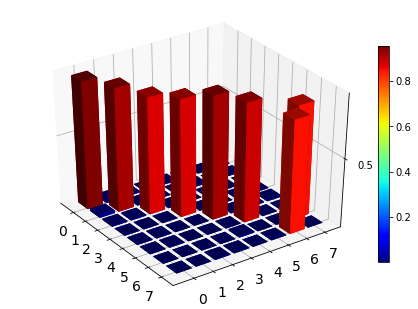

In [8]:
#list to hold results
margolus_results = []

for i in range(qubit_states_3_num):
    state1 = RY(qubit_states_3[i],N3,2,np.pi/4,1)
    state2 = CNOT(state1,N3,2,1)
    state3 = RY(state2,N3,2,np.pi/4,1)
    state4 = CNOT(state3,N3,2,0)
    state5 = RY(state4,N3,2,-1*(np.pi/4),1)
    state6 = CNOT(state5,N3,2,1)
    state7 = RY(state6,N3,2,-1*(np.pi/4),1)
    #state8 = state7*measurement
    margolus_results.append(state7)

margolus_qpt = []
for i in range(qubit_states_3_num):
    state_qpt = []
    for j in range(qubit_states_3_num):
        #calculate fidelities
        fid = (margolus_results[i].sqrtm()*qubit_states_3[j]*margolus_results[i].sqrtm())
        fid = fid.sqrtm()
        fid = fid.tr()*fid.tr()
        state_qpt.append(fid)
        
    margolus_qpt.append(state_qpt)


margolus_array = np.array(margolus_qpt)
margolus_array = np.sqrt(margolus_array)
#xlabel=['000','001','010','011','100','101','110','111']
if(array_analysis):
    margolus_array
else:
    fig,ax = matrix_histogram(margolus_array)

0.91833820194573723

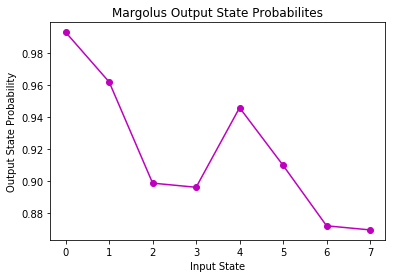

In [9]:
x = range(qubit_states_3_num)
y = np.real(np.sum(margolus_array,axis=0))
plt.plot(x,y,'mo-')
plt.xlabel("Input State")
plt.ylabel("Output State Probability")
plt.title("Margolus Output State Probabilites")
avg_fid_marg = (1/qubit_states_3_num)*np.sum(y)
avg_fid_marg

# Toffoli Gate

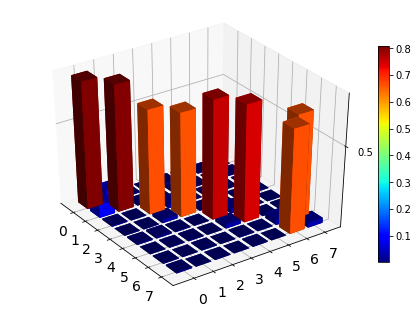

In [10]:
#list to hold results
toffoli_results = []


for i in range(qubit_states_3_num):
    
    state1 = H(qubit_states_3[i],N3,2)
    state2 = T_dag(state1,N3,1)
    state3 = T_dag(state2,N3,0)
    state4 = CNOT(state3,N3,0,2)
    state5 = CNOT(state4,N3,2,1)
    state6 = T(state5,N3,0)
    state7 = T(state6,N3,2)
    state8 = CNOT(state7,N3,0,1)
    state9 = CNOT(state8,N3,2,1)
    state10 = T_dag(state9,N3,0)
    state11 = CNOT(state10,N3,0,2)
    state12 = T_dag(state11,N3,2)
    state13 = T(state12,N3,0)
    state14 = H(state13,N3,2)
    state15 = CNOT(state14,N3,0,1)
    
    toffoli_results.append(state15)

toffoli_qpt = []
for i in range(qubit_states_3_num):
    state_qpt = []
    for j in range(qubit_states_3_num):
        #calculate fidelities
        fid = (toffoli_results[i].sqrtm()*qubit_states_3[j]*toffoli_results[i].sqrtm())
        fid = fid.sqrtm()
        fid = fid.tr()*fid.tr()
        state_qpt.append(fid)
        
    toffoli_qpt.append(state_qpt)

toffoli_array = np.array(toffoli_qpt)
toffoli_array=np.sqrt(toffoli_array)
if(array_analysis):
    toffoli_array
else:
    fig,ax = matrix_histogram(toffoli_array)

0.79195049267501449

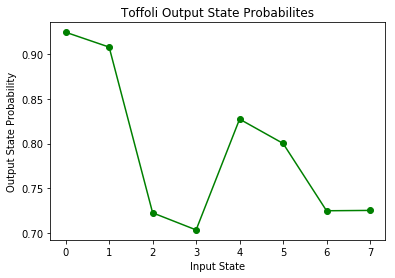

In [11]:
x = range(qubit_states_3_num)
y = np.real(np.sum(toffoli_array,axis=0))
plt.plot(x,y,'go-')
plt.xlabel("Input State")
plt.ylabel("Output State Probability")
plt.title("Toffoli Output State Probabilites")
avg_fid_tof = (1/qubit_states_3_num)*np.sum(y)
avg_fid_tof

# Bernstein-Vazirani Algorithm

In [12]:
#list to hold results
bv_results = []

#superposition state
state1 = H(qubit_states_5[0],N5,0)
state2 = H(state1,N5,1)
state3 = H(state2,N5,2)
state4 = H(state3,N5,3)
state5 = H(state4,N5,4)

for i in range(qubit_states_5_num):  
    #conditionals for different oracle configurations
    if(i==0):
        state6 = H(state5,N5,0)
        state7 = H(state6,N5,1)
        state8 = H(state7,N5,2)
        state9 = H(state8,N5,3)
        state10 = H(state9,N5,4)
        
        result = state10.ptrace([0,1,2,3])
        bv_results.append(result)
    elif(i==1):
        state6 = CNOT(state5,N5,4,3)
        state7 = H(state6,N5,0)
        state8 = H(state7,N5,1)
        state9 = H(state8,N5,2)
        state10 = H(state9,N5,3)
        state11 = H(state10,N5,4)
        
        result = state11.ptrace([0,1,2,3])
        bv_results.append(result)
    elif(i==2):
        state6 = CNOT(state5,N5,4,2)
        state7 = H(state6,N5,0)
        state8 = H(state7,N5,1)
        state9 = H(state8,N5,2)
        state10 = H(state9,N5,3)
        state11 = H(state10,N5,4)
        
        result = state11.ptrace([0,1,2,3])
        bv_results.append(result)
    elif(i==3):
        state6 = CNOT(state5,N5,4,3)
        state7 = CNOT(state6,N5,4,2)
        state8 = H(state7,N5,0)
        state9 = H(state8,N5,1)
        state10 = H(state9,N5,2)
        state11 = H(state10,N5,3)
        state12 = H(state11,N5,4)
        
        result = state12.ptrace([0,1,2,3])
        bv_results.append(result)
    elif(i==4):
        state6 = CNOT(state5,N5,4,1)
        state7 = H(state6,N5,0)
        state8 = H(state7,N5,1)
        state9 = H(state8,N5,2)
        state10 = H(state9,N5,3)
        state11 = H(state10,N5,4)
        
        result = state11.ptrace([0,1,2,3])
        bv_results.append(result)
    elif(i==5):
        state6 = CNOT(state5,N5,4,3)
        state7 = CNOT(state6,N5,4,1)
        state8 = H(state7,N5,0)
        state9 = H(state8,N5,1)
        state10 = H(state9,N5,2)
        state11 = H(state10,N5,3)
        state12 = H(state11,N5,4)
        
        result = state12.ptrace([0,1,2,3])
        bv_results.append(result)
    elif(i==6):
        state6 = CNOT(state5,N5,4,2)
        state7 = CNOT(state6,N5,4,1)
        state8 = H(state7,N5,0)
        state9 = H(state8,N5,1)
        state10 = H(state9,N5,2)
        state11 = H(state10,N5,3)
        state12 = H(state11,N5,4)
        
        result = state12.ptrace([0,1,2,3])
        bv_results.append(result)
    elif(i==7):
        state6 = CNOT(state5,N5,4,3)
        state7 = CNOT(state6,N5,4,2)
        state8 = CNOT(state7,N5,4,1)
        state9 = H(state8,N5,0)
        state10 = H(state9,N5,1)
        state11 = H(state10,N5,2)
        state12 = H(state11,N5,3)
        state13 = H(state12,N5,4)
        
        result = state13.ptrace([0,1,2,3])
        bv_results.append(result)
    elif(i==8):
        state6 = CNOT(state5,N5,4,0)
        state7 = H(state6,N5,0)
        state8 = H(state7,N5,1)
        state9 = H(state8,N5,2)
        state10 = H(state9,N5,3)
        state11 = H(state10,N5,4)
        
        result = state11.ptrace([0,1,2,3])
        bv_results.append(result)
    elif(i==9):
        state6 = CNOT(state5,N5,4,0)
        state7 = CNOT(state6,N5,4,3)
        state8 = H(state7,N5,0)
        state9 = H(state8,N5,1)
        state10 = H(state9,N5,2)
        state11 = H(state10,N5,3)
        state12 = H(state11,N5,4)
        
        result = state12.ptrace([0,1,2,3])
        bv_results.append(result)
    elif(i==10):
        state6 = CNOT(state5,N5,4,0)
        state7 = CNOT(state6,N5,4,2)
        state8 = H(state7,N5,0)
        state9 = H(state8,N5,1)
        state10 = H(state9,N5,2)
        state11 = H(state10,N5,3)
        state12 = H(state11,N5,4)
        
        result = state12.ptrace([0,1,2,3])
        bv_results.append(result)
    elif(i==11):
        state6 = CNOT(state5,N5,4,0)
        state7 = CNOT(state6,N5,4,2)
        state8 = CNOT(state7,N5,4,3)
        state9 = H(state8,N5,0)
        state10 = H(state9,N5,1)
        state11 = H(state10,N5,2)
        state12 = H(state11,N5,3)
        state13 = H(state12,N5,4)
        
        result = state13.ptrace([0,1,2,3])
        bv_results.append(result)
    elif(i==12):
        state6 = CNOT(state5,N5,4,1)
        state7 = CNOT(state6,N5,4,0)
        state8 = H(state7,N5,0)
        state9 = H(state8,N5,1)
        state10 = H(state9,N5,2)
        state11 = H(state10,N5,3)
        state12 = H(state11,N5,4)
        
        result = state12.ptrace([0,1,2,3])
        bv_results.append(result)
    elif(i==13):
        state6 = CNOT(state5,N5,4,1)
        state7 = CNOT(state6,N5,4,0)
        state8 = CNOT(state7,N5,4,3)
        state9 = H(state8,N5,0)
        state10 = H(state9,N5,1)
        state11 = H(state10,N5,2)
        state12 = H(state11,N5,3)
        state13 = H(state12,N5,4)
        
        result = state13.ptrace([0,1,2,3])
        bv_results.append(result)
    elif(i==14):
        state6 = CNOT(state5,N5,4,1)
        state7 = CNOT(state6,N5,4,2)
        state8 = CNOT(state7,N5,4,0)
        state9 = H(state8,N5,0)
        state10 = H(state9,N5,1)
        state11 = H(state10,N5,2)
        state12 = H(state11,N5,3)
        state13 = H(state12,N5,4)
        
        result = state13.ptrace([0,1,2,3])
        bv_results.append(result)
    else:
        state6 = CNOT(state5,N5,4,0)
        state7 = CNOT(state6,N5,4,1)
        state8 = CNOT(state7,N5,4,2)
        state9 = CNOT(state8,N5,4,3)
        state10 = H(state9,N5,0)
        state11 = H(state10,N5,1)
        state12 = H(state11,N5,2)
        state13 = H(state12,N5,3)
        state14 = H(state13,N5,4)
        
        result = state14.ptrace([0,1,2,3])
        bv_results.append(result)


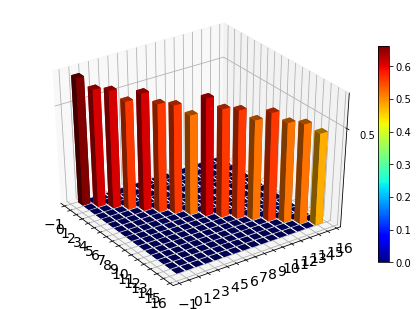

In [13]:
bv_qpt = []
for i in range(qubit_states_5_num):
    state_qpt = []
    for j in range(qubit_states_5_num):
        #calculate fidelities
        fid = bv_results[i].sqrtm()*(qubit_states_5[j].ptrace([0,1,2,3]))*bv_results[i].sqrtm()
        fid = fid.sqrtm()
        fid = fid.tr()*fid.tr()
        state_qpt.append(fid)
        
    bv_qpt.append(state_qpt)

bv_array = np.array(bv_qpt)
fig,ax = matrix_histogram(bv_array)

0.56680945344257927

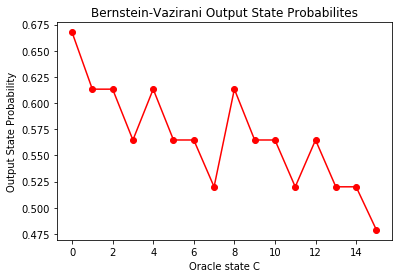

In [14]:
x = range(qubit_states_5_num)
y = np.real(np.sum(bv_array,axis=0))
plt.plot(x,y,'ro-')
plt.xlabel("Oracle state C")
plt.ylabel("Output State Probability")
plt.title("Bernstein-Vazirani Output State Probabilites")
avg_fid_bv = (1/qubit_states_5_num)*np.sum(y)
avg_fid_bv

# Hidden Shift Algorithm

In [15]:
#list to hold results
hs_results = []

#superposition state
state1 = H(qubit_states_4[0],N4,0)
state2 = H(state1,N4,1)
state3 = H(state2,N4,2)
state4 = H(state3,N4,3)

for i in range(qubit_states_4_num):
    #conditionals for different oracle configurations
    if(i==0):
        state5 = CPHASE(state4,N4,1,0,np.pi)
        state6 = CPHASE(state5,N4,3,2,np.pi)
        state7 = H(state6,N4,0)
        state8 = H(state7,N4,1)
        state9 = H(state8,N4,2)
        state10 = H(state9,N4,3)
        state11 = CPHASE(state10,N4,1,0,np.pi)
        state12 = CPHASE(state11,N4,3,2,np.pi)
        state13 = H(state12,N4,0)
        state14 = H(state13,N4,1)
        state15 = H(state14,N4,2)
        state16 = H(state15,N4,3)
        
        hs_results.append(state16)    
    elif(i==1):
        state5 = RX(state4,N4,3,np.pi,1)
        state6 = CPHASE(state5,N4,1,0,np.pi)
        state7 = CPHASE(state6,N4,3,2,np.pi)
        state8 = RX(state7,N4,3,np.pi,1)
        state9 = H(state8,N4,0)
        state10 = H(state9,N4,1)
        state11 = H(state10,N4,2)
        state12 = H(state11,N4,3)
        state13 = CPHASE(state12,N4,1,0,np.pi)
        state14 = CPHASE(state13,N4,3,2,np.pi)
        state15 = H(state14,N4,0)
        state16 = H(state15,N4,1)
        state17 = H(state16,N4,2)
        state18 = H(state17,N4,3)
        
        hs_results.append(state18)   
    elif(i==2):
        state5 = RX(state4,N4,2,np.pi,1)
        state6 = CPHASE(state5,N4,1,0,np.pi)
        state7 = CPHASE(state6,N4,3,2,np.pi)
        state8 = RX(state7,N4,2,np.pi,1)
        state9 = H(state8,N4,0)
        state10 = H(state9,N4,1)
        state11 = H(state10,N4,2)
        state12 = H(state11,N4,3)
        state13 = CPHASE(state12,N4,1,0,np.pi)
        state14 = CPHASE(state13,N4,3,2,np.pi)
        state15 = H(state14,N4,0)
        state16 = H(state15,N4,1)
        state17 = H(state16,N4,2)
        state18 = H(state17,N4,3)
        
        hs_results.append(state18)    
    elif(i==3):
        state5 = RX(state4,N4,3,np.pi,1)
        state6 = RX(state5,N4,2,np.pi,1)
        state7 = CPHASE(state6,N4,1,0,np.pi)
        state8 = CPHASE(state7,N4,3,2,np.pi)
        state9 = RX(state8,N4,3,np.pi,1)
        state10 = RX(state9,N4,2,np.pi,1)
        state11 = H(state10,N4,0)
        state12 = H(state11,N4,1)
        state13 = H(state12,N4,2)
        state14 = H(state13,N4,3)
        state15 = CPHASE(state14,N4,1,0,np.pi)
        state16 = CPHASE(state15,N4,3,2,np.pi)
        state17 = H(state16,N4,0)
        state18 = H(state17,N4,1)
        state19 = H(state18,N4,2)
        state20 = H(state19,N4,3)
        
        hs_results.append(state20)   
    elif(i==4):
        state5 = RX(state4,N4,1,np.pi,1)
        state6 = CPHASE(state5,N4,1,0,np.pi)
        state7 = CPHASE(state6,N4,3,2,np.pi)
        state8 = RX(state7,N4,1,np.pi,1)
        state9 = H(state8,N4,0)
        state10 = H(state9,N4,1)
        state11 = H(state10,N4,2)
        state12 = H(state11,N4,3)
        state13 = CPHASE(state12,N4,1,0,np.pi)
        state14 = CPHASE(state13,N4,3,2,np.pi)
        state15 = H(state14,N4,0)
        state16 = H(state15,N4,1)
        state17 = H(state16,N4,2)
        state18 = H(state17,N4,3)
        
        hs_results.append(state18)   
    elif(i==5):
        state5 = RX(state4,N4,3,np.pi,1)
        state6 = RX(state5,N4,1,np.pi,1)
        state7 = CPHASE(state6,N4,1,0,np.pi)
        state8 = CPHASE(state7,N4,3,2,np.pi)
        state9 = RX(state8,N4,3,np.pi,1)
        state10 = RX(state9,N4,1,np.pi,1)
        state11 = H(state10,N4,0)
        state12 = H(state11,N4,1)
        state13 = H(state12,N4,2)
        state14 = H(state13,N4,3)
        state15 = CPHASE(state14,N4,1,0,np.pi)
        state16 = CPHASE(state15,N4,3,2,np.pi)
        state17 = H(state16,N4,0)
        state18 = H(state17,N4,1)
        state19 = H(state18,N4,2)
        state20 = H(state19,N4,3)
        
        hs_results.append(state20)  
    elif(i==6):
        state5 = RX(state4,N4,2,np.pi,1)
        state6 = RX(state5,N4,1,np.pi,1)
        state7 = CPHASE(state6,N4,1,0,np.pi)
        state8 = CPHASE(state7,N4,3,2,np.pi)
        state9 = RX(state8,N4,2,np.pi,1)
        state10 = RX(state9,N4,1,np.pi,1)
        state11 = H(state10,N4,0)
        state12 = H(state11,N4,1)
        state13 = H(state12,N4,2)
        state14 = H(state13,N4,3)
        state15 = CPHASE(state14,N4,1,0,np.pi)
        state16 = CPHASE(state15,N4,3,2,np.pi)
        state17 = H(state16,N4,0)
        state18 = H(state17,N4,1)
        state19 = H(state18,N4,2)
        state20 = H(state19,N4,3)
        
        hs_results.append(state20)  
    elif(i==7):
        state5 = RX(state4,N4,1,np.pi,1)
        state6 = RX(state5,N4,2,np.pi,1)
        state7 = RX(state6,N4,3,np.pi,1)
        state8 = CPHASE(state7,N4,1,0,np.pi)
        state9 = CPHASE(state8,N4,3,2,np.pi)
        state10 = RX(state9,N4,3,np.pi,1)
        state11 = RX(state10,N4,2,np.pi,1)
        state12 = RX(state11,N4,1,np.pi,1)
        state13 = H(state12,N4,0)
        state14 = H(state13,N4,1)
        state15 = H(state14,N4,2)
        state16 = H(state15,N4,3)
        state17 = CPHASE(state16,N4,1,0,np.pi)
        state18 = CPHASE(state17,N4,3,2,np.pi)
        state19 = H(state18,N4,0)
        state20 = H(state19,N4,1)
        state21 = H(state20,N4,2)
        state22 = H(state21,N4,3)
        
        hs_results.append(state22)  
    elif(i==8):
        state5 = RX(state4,N4,0,np.pi,1)
        state6 = CPHASE(state5,N4,1,0,np.pi)
        state7 = CPHASE(state6,N4,3,2,np.pi)
        state8 = RX(state7,N4,0,np.pi,1)
        state9 = H(state8,N4,0)
        state10 = H(state9,N4,1)
        state11 = H(state10,N4,2)
        state12 = H(state11,N4,3)
        state13 = CPHASE(state12,N4,1,0,np.pi)
        state14 = CPHASE(state13,N4,3,2,np.pi)
        state15 = H(state14,N4,0)
        state16 = H(state15,N4,1)
        state17 = H(state16,N4,2)
        state18 = H(state17,N4,3)
        
        hs_results.append(state18)  
    elif(i==9):
        state5 = RX(state4,N4,0,np.pi,1)
        state6 = RX(state5,N4,3,np.pi,1)
        state7 = CPHASE(state6,N4,1,0,np.pi)
        state8 = CPHASE(state7,N4,3,2,np.pi)
        state9 = RX(state8,N4,0,np.pi,1)
        state10 = RX(state9,N4,3,np.pi,1)
        state11 = H(state10,N4,0)
        state12 = H(state11,N4,1)
        state13 = H(state12,N4,2)
        state14 = H(state13,N4,3)
        state15 = CPHASE(state14,N4,1,0,np.pi)
        state16 = CPHASE(state15,N4,3,2,np.pi)
        state17 = H(state16,N4,0)
        state18 = H(state17,N4,1)
        state19 = H(state18,N4,2)
        state20 = H(state19,N4,3)
        
        hs_results.append(state20)   
    elif(i==10):
        state5 = RX(state4,N4,0,np.pi,1)
        state6 = RX(state5,N4,2,np.pi,1)
        state7 = CPHASE(state6,N4,1,0,np.pi)
        state8 = CPHASE(state7,N4,3,2,np.pi)
        state9 = RX(state8,N4,0,np.pi,1)
        state10 = RX(state9,N4,2,np.pi,1)
        state11 = H(state10,N4,0)
        state12 = H(state11,N4,1)
        state13 = H(state12,N4,2)
        state14 = H(state13,N4,3)
        state15 = CPHASE(state14,N4,1,0,np.pi)
        state16 = CPHASE(state15,N4,3,2,np.pi)
        state17 = H(state16,N4,0)
        state18 = H(state17,N4,1)
        state19 = H(state18,N4,2)
        state20 = H(state19,N4,3)
        
        hs_results.append(state20)    
    elif(i==11):
        state5 = RX(state4,N4,0,np.pi,1)
        state6 = RX(state5,N4,2,np.pi,1)
        state7 = RX(state6,N4,3,np.pi,1)
        state8 = CPHASE(state7,N4,1,0,np.pi)
        state9 = CPHASE(state8,N4,3,2,np.pi)
        state10 = RX(state9,N4,0,np.pi,1)
        state11 = RX(state10,N4,2,np.pi,1)
        state12 = RX(state11,N4,3,np.pi,1)
        state13 = H(state12,N4,0)
        state14 = H(state13,N4,1)
        state15 = H(state14,N4,2)
        state16 = H(state15,N4,3)
        state17 = CPHASE(state16,N4,1,0,np.pi)
        state18 = CPHASE(state17,N4,3,2,np.pi)
        state19 = H(state18,N4,0)
        state20 = H(state19,N4,1)
        state21 = H(state20,N4,2)
        state22 = H(state21,N4,3)
        
        hs_results.append(state22)    
    elif(i==12):
        state5 = RX(state4,N4,0,np.pi,1)
        state6 = RX(state5,N4,1,np.pi,1)
        state7 = CPHASE(state6,N4,1,0,np.pi)
        state8 = CPHASE(state7,N4,3,2,np.pi)
        state9 = RX(state8,N4,0,np.pi,1)
        state10 = RX(state9,N4,1,np.pi,1)
        state11 = H(state10,N4,0)
        state12 = H(state11,N4,1)
        state13 = H(state12,N4,2)
        state14 = H(state13,N4,3)
        state15 = CPHASE(state14,N4,1,0,np.pi)
        state16 = CPHASE(state15,N4,3,2,np.pi)
        state17 = H(state16,N4,0)
        state18 = H(state17,N4,1)
        state19 = H(state18,N4,2)
        state20 = H(state19,N4,3)
        
        hs_results.append(state20)  
    elif(i==13):
        state5 = RX(state4,N4,0,np.pi,1)
        state6 = RX(state5,N4,1,np.pi,1)
        state7 = RX(state6,N4,3,np.pi,1)
        state8 = CPHASE(state7,N4,1,0,np.pi)
        state9 = CPHASE(state8,N4,3,2,np.pi)
        state10 = RX(state9,N4,0,np.pi,1)
        state11 = RX(state10,N4,1,np.pi,1)
        state12 = RX(state11,N4,3,np.pi,1)
        state13 = H(state12,N4,0)
        state14 = H(state13,N4,1)
        state15 = H(state14,N4,2)
        state16 = H(state15,N4,3)
        state17 = CPHASE(state16,N4,1,0,np.pi)
        state18 = CPHASE(state17,N4,3,2,np.pi)
        state19 = H(state18,N4,0)
        state20 = H(state19,N4,1)
        state21 = H(state20,N4,2)
        state22 = H(state21,N4,3)
        
        hs_results.append(state22)   
    elif(i==14):
        state5 = RX(state4,N4,0,np.pi,1)
        state6 = RX(state5,N4,1,np.pi,1)
        state7 = RX(state6,N4,2,np.pi,1)
        state8 = CPHASE(state7,N4,1,0,np.pi)
        state9 = CPHASE(state8,N4,3,2,np.pi)
        state10 = RX(state9,N4,0,np.pi,1)
        state11 = RX(state10,N4,1,np.pi,1)
        state12 = RX(state11,N4,2,np.pi,1)
        state13 = H(state12,N4,0)
        state14 = H(state13,N4,1)
        state15 = H(state14,N4,2)
        state16 = H(state15,N4,3)
        state17 = CPHASE(state16,N4,1,0,np.pi)
        state18 = CPHASE(state17,N4,3,2,np.pi)
        state19 = H(state18,N4,0)
        state20 = H(state19,N4,1)
        state21 = H(state20,N4,2)
        state22 = H(state21,N4,3)
        
        hs_results.append(state22)    
    else:
        state5 = RX(state4,N4,0,np.pi,1)
        state6 = RX(state5,N4,1,np.pi,1)
        state7 = RX(state6,N4,2,np.pi,1)
        state8 = RX(state7,N4,3,np.pi,1)
        state9 = CPHASE(state8,N4,1,0,np.pi)
        state10 = CPHASE(state9,N4,3,2,np.pi)
        state11 = RX(state10,N4,0,np.pi,1)
        state12 = RX(state11,N4,1,np.pi,1)
        state13 = RX(state12,N4,2,np.pi,1)
        state14 = RX(state13,N4,3,np.pi,1)
        state15 = H(state14,N4,0)
        state16 = H(state15,N4,1)
        state17 = H(state16,N4,2)
        state18 = H(state17,N4,3)
        state19 = CPHASE(state18,N4,1,0,np.pi)
        state20 = CPHASE(state19,N4,3,2,np.pi)
        state21 = H(state20,N4,0)
        state22 = H(state21,N4,1)
        state23 = H(state22,N4,2)
        state24 = H(state23,N4,3)
        
        hs_results.append(state24)


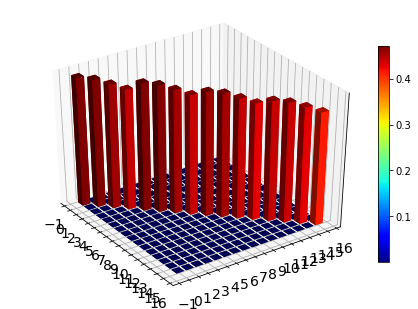

In [16]:
hs_qpt = []
for i in range(qubit_states_4_num):
    state_qpt = []
    for j in range(qubit_states_4_num):
        #calculate fidelities
        fid = hs_results[i].sqrtm()*qubit_states_4[j]*hs_results[i].sqrtm()
        fid = fid.sqrtm()
        fid = fid.tr()*fid.tr()
        state_qpt.append(fid)
        
    hs_qpt.append(state_qpt)

hs_array = np.array(hs_qpt)
fig,ax = matrix_histogram(hs_array)

0.45040840063680559

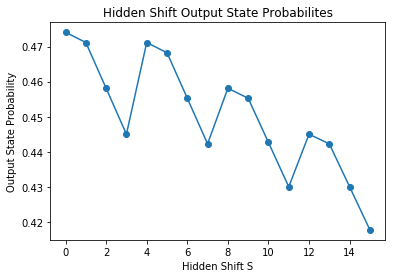

In [17]:
x = range(qubit_states_4_num)
y = np.real(np.sum(hs_array,axis=0))
plt.plot(x,y,'o-')
plt.xlabel("Hidden Shift S")
plt.ylabel("Output State Probability")
plt.title("Hidden Shift Output State Probabilites")
avg_fid_hs = (1/qubit_states_5_num)*np.sum(y)
avg_fid_hs

# References

(1) Debnath, et. al (2016): https://arxiv.org/pdf/1603.04512.pdf